In [ ]:
from codigos.kagglehub_data import get_data, preprocess_trips, build_pools
from codigos.nodes import nodes, coords
from codigos.sample_SAA import sample_SAA
from codigos.plot import plot_route_basic,plot_route_with_basemap
from codigos.set_model import *
from codigos.clean_pool import *
from codigos.l_shape import *
import pandas as pd

/home/ebrios/anaconda3/envs/optest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = get_data() 

# 2) Limpiar coordenadas y duración 1–120 min
df = preprocess_trips(df)


Data loaded from file.


In [3]:
pools, summary_df = build_pools(
    df=df,
    nodes=nodes,
    r_init=250,
    r_max=400,
    step=50,
    m_min=50,
    allow_time_fallback=True
)

# Guarda un resumen para tu informe
summary_df.to_csv("csv/pools_summary.csv", index=False)

# Uso
df_pools = pools_to_df(pools)

# df_pools: columnas i, j, t_min (todas las observaciones de todos los arcos)
# boxplot_por_arco(df_pools, guardar="imagenes/boxplots_arcos.png")

clean_pool = clean_outliers_iqr(pools)
df_clean_pools = pools_to_df(clean_pool)

# df_pools: columnas i, j, t_min (todas las observaciones de todos los arcos)
# boxplot_por_arco(df_clean_pools, guardar="imagenes/boxplots_arcos_limpios.png")

# Ejemplo de uso:
K = 50
T_list, T_frames = sample_SAA(clean_pool, K=K, seed=69)

Arc (0->1): 520 obs, ventana=09-17, radio_final=250
Arc (0->2): 208 obs, ventana=09-17, radio_final=250
Arc (0->3): 386 obs, ventana=09-17, radio_final=250
Arc (0->4): 231 obs, ventana=09-17, radio_final=250
Arc (0->5): 77 obs, ventana=09-17, radio_final=250
Arc (0->6): 59 obs, ventana=09-17, radio_final=350
Arc (0->7): 906 obs, ventana=09-17, radio_final=250
Arc (0->8): 74 obs, ventana=09-17, radio_final=250
Arc (0->9): 50 obs, ventana=09-17, radio_final=250
Arc (0->10): 106 obs, ventana=09-17, radio_final=350
Arc (0->11): 38 obs, ventana=09-17, radio_final=None
Arc (1->0): 1426 obs, ventana=09-17, radio_final=250
Arc (1->2): 561 obs, ventana=09-17, radio_final=250
Arc (1->3): 843 obs, ventana=09-17, radio_final=250
Arc (1->4): 369 obs, ventana=09-17, radio_final=250
Arc (1->5): 252 obs, ventana=09-17, radio_final=250
Arc (1->6): 70 obs, ventana=09-17, radio_final=250
Arc (1->7): 2629 obs, ventana=09-17, radio_final=250
Arc (1->8): 375 obs, ventana=09-17, radio_final=250
Arc (1->9): 4

In [4]:
new_T_frame = []

for i in range(len(T_frames)):
    new_T_frame.append(build_c(12,T_frames[i]))

T_list = build_T_list(pools, K=50)

V = list(range(12))
depot = 0
N = [i for i in V if i != depot]
c = pd.read_csv('csv/matriz_distancias_conduccion.csv')
c = c.drop(columns='Sitio')
c.columns = list(c.index)

c_dicc = dataframe_to_c(c)

H = 480

d_i = {
    1: 30,
    2: 30,
    3: 35,
    4: 30,
    5: 25,
    6: 25,
    7: 35,
    8: 30,
    9: 40,
    10: 35,
    11: 25
}         # demandas por nodo i ∈ N

alpha = {i: 1.0 for i in N}  # productividad


In [ ]:
res = solve_lshaped(
    V=V, depot=depot,
    c=c_dicc, T_list=new_T_frame,
    H=H, d=d_i, alpha=alpha,
    verbose=True
)

print("Ruta óptima:", res["route"])
print("Costo esperado:", res["obj"])

Restricted license - for non-production use only - expires 2026-11-23
Set parameter OutputFlag to value 1

--- Iteración 1 ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 134 rows, 193 columns and 594 nonzeros
Model fingerprint: 0x6b617d12
Variable types: 61 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e-02, 1e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 50 columns
Presolve time: 0.00s
Presolved: 134 rows, 143 columns, 1188 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)
Found heuristic solution: objective 59.8200000
Found heuristic solution: objective 55.6300000
Found heuristic solution: objective 50.0800000

Root relaxation

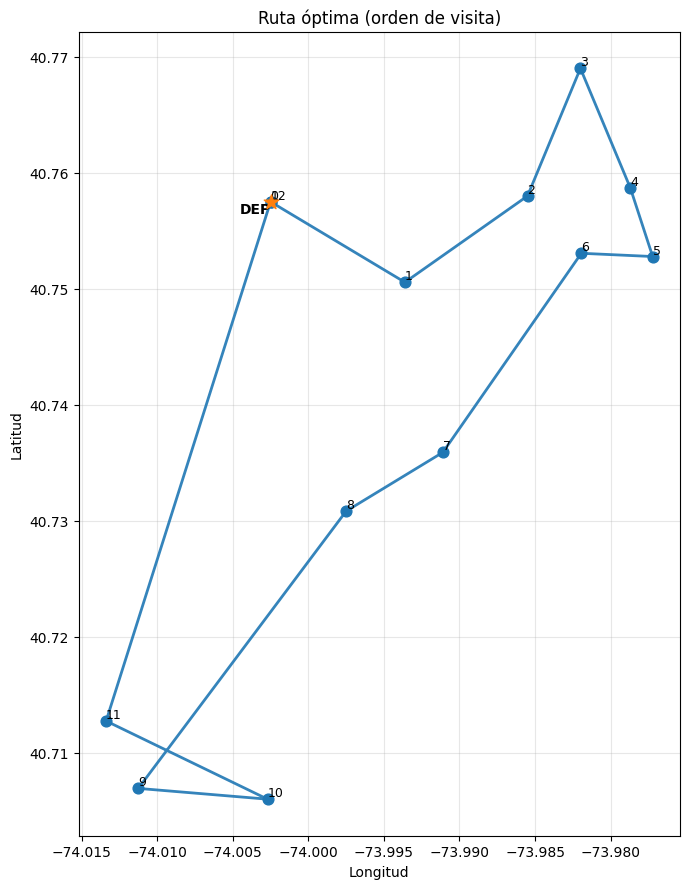

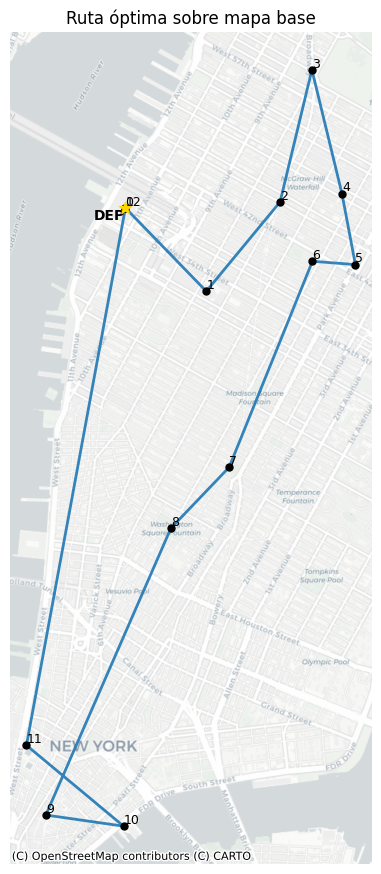

In [7]:
plot_route_basic(coords, res["route"])
plot_route_with_basemap(coords, res["route"])
